In [1]:
#These lines are used to mount the drive when using GOOGLE COLAB. Ignore else.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
ls

drive/  sample_data/


In [3]:
#the below line is to download the cats and dogs dataset.
!wget "https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip"

--2020-06-29 13:52:13--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.169.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.169.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  16.1MB/s    in 36s     

2020-06-29 13:52:50 (15.4 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [4]:
ls

Cat_Dog_data.zip  drive/  sample_data/


In [5]:
#unzip the downloaded dataset
!unzip -qq Cat_Dog_data.zip

In [6]:
#ls -U | head -10

In [2]:
#importing the libraries
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#defining the transformations for training images
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#defining the transformations for tesing images
test_transform = transforms.Compose([transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#loading the training and testing dataset and applying the transformations defined above
trainset = datasets.ImageFolder('Cat_Dog_data/train/', transform=train_transform)
testset = datasets.ImageFolder('Cat_Dog_data/test/', transform=test_transform)

#defining the generators that can be used to get images and labels
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [10]:
#Doing this because, sometimes we get an error 'module 'PIL.Image' has no attribute 'register_extensions' in GOOGLE COLAB
#uninstall the old one
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==4.1.1

Uninstalling Pillow-4.1.1:
  Successfully uninstalled Pillow-4.1.1
  Using cached https://files.pythonhosted.org/packages/36/e5/88b3d60924a3f8476fa74ec086f5fbaba56dd6cee0d82845f883b6b6dd18/Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


(3, 224, 224)
tensor(1)


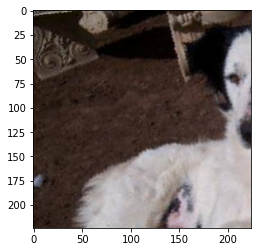

In [4]:
#visualising the images
images, labels = next(iter(trainloader))
print(images[0].numpy().shape)
img = images[5].numpy().transpose(1,2,0)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)

print(labels[5])

In [5]:
#downloading the pretrained model
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
# We will keep the features part static and update the classifier part

#Freeze our feature parameters
for param in model.parameters():
    param.requires_grad = False
  
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('dropout1', nn.Dropout(0.2)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [7]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#moving the model to 'cuda' if available else 'cpu'
model.to(device)
torch.cuda.is_available()

False

In [8]:
#defining the function for validating the model
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        #images = images.view(images.shape[0], -1)
        
        logits = model(images)
        ps = torch.exp(logits)
        
        test_loss += criterion(logits, labels).item()
        
        top_k, top_class  = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    return accuracy, test_loss

In [10]:
#defining the function to train the model
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=50):
    #print('train def')
    training_loss = 0
    steps = 0
    
    for e in range(epochs):
        #print('epoch start')
        model.train()
        
        for images, labels in trainloader:
            #print('images start')
            images, labels = images.to(device), labels.to(device)
            steps += 1
            #images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            
            #print('optimizer zero grad')

            logits = model(images)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            #print('loss item')
            
            if steps%print_every == 0:
                model.eval()
                
                accuracy = 0
                test_loss = 0
                with torch.no_grad():
                    accuracy, test_loss = validation(model, testloader, criterion)
                
                print('Epoch {}/{}: '.format(e+1, epochs),
                     'Training Loss {:.3f} '.format(training_loss/print_every),
                     'Test Loss {:.3f} '.format(test_loss/len(testloader)),
                     'Test Accuracy {:.3f}'.format(accuracy/len(testloader)))
                
                training_loss = 0
                model.train()

In [11]:
train(model, trainloader, testloader, criterion, optimizer, 1)

Epoch 1/1:  Training Loss 49.568  Test Loss 0.318  Test Accuracy 0.927
Epoch 1/1:  Training Loss 0.663  Test Loss 0.126  Test Accuracy 0.973
Epoch 1/1:  Training Loss 0.268  Test Loss 0.108  Test Accuracy 0.968
Epoch 1/1:  Training Loss 0.310  Test Loss 0.110  Test Accuracy 0.958
Epoch 1/1:  Training Loss 0.320  Test Loss 0.082  Test Accuracy 0.976
Epoch 1/1:  Training Loss 0.250  Test Loss 0.075  Test Accuracy 0.978
Epoch 1/1:  Training Loss 0.273  Test Loss 0.073  Test Accuracy 0.979
Epoch 1/1:  Training Loss 0.239  Test Loss 0.070  Test Accuracy 0.975
Epoch 1/1:  Training Loss 0.266  Test Loss 0.064  Test Accuracy 0.978
Epoch 1/1:  Training Loss 0.246  Test Loss 0.063  Test Accuracy 0.982
Epoch 1/1:  Training Loss 0.251  Test Loss 0.075  Test Accuracy 0.978
Epoch 1/1:  Training Loss 0.246  Test Loss 0.059  Test Accuracy 0.981
Epoch 1/1:  Training Loss 0.234  Test Loss 0.059  Test Accuracy 0.978
Epoch 1/1:  Training Loss 0.233  Test Loss 0.063  Test Accuracy 0.975


In [ ]:
#saving the checkpoint because if we want to use the model, we do not need to train it again. we can use the weights from the trained model.
checkpoint = {
    'input_size': 1024,
    'output_size': 2,
    'hidden_size': [500],
    'state_dict': model.state_dict()
             }
torch.save(checkpoint, 'drive/My Drive/Colab Notebooks/Deep Learning/Classifying Dogs and Cats/checkpoint.pth')

Probability of Cat:0.547807514667511
Probability of Dog:0.4521924555301666

Actual Output: Cat


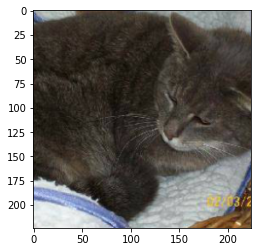

In [12]:
#visualising the trained model
images, labels = next(iter(testloader))
images = images.to(device)

logits = model(images[0].view(-1, 3, 224, 224))
output = torch.exp(logits)


img = images[0].cpu().numpy().transpose(1,2,0)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)

print('Probability of Cat:{}\nProbability of Dog:{}\n'.format(output[0][0], output[0][1]))
if labels[0].item()==0:
  print('Actual Output: Cat')
else:
  print('Actual Output: Dog')